## Repackage e-images...

In [1]:
import os
import sys
import glob
import time
from collections import defaultdict
import astropy.io.fits as fits
import astropy.time
from lsst.obs.lsst import LsstCam

#visit_dir = '/project/scichris/repackagerTest/extra' # for comcam 
visit_dir = '/project/scichris/repackagerTest/intra'# for wfs 

*PROGRAMMATIC OUTLINE *

    def **process_visit_eimage**( visit_dir, out_dir=None, prefix='lsst', verbose=False ) 
                             
        checks for input files
        iterates over sensors
            calls repackage_eimage_corner or repackage_eimage_main depending on sensor names
                             
                            
        def repackage_eimage_corner (phosim_eimg_file, camera , out_dir='.')
            reads the eimage fits file (single HDU)
            adds appropriate header info for main header
            creates filename from TELCODE, CONTRLLR (__init__),
                                  DAYOBS (from converting phosim MJD-OBS header), 
                                  SEQNUM (a random number) , raft (from input filename), 
                                  ccdslot (whether SW0 or SW1) 
            saves the file 
                             
        def repackage_eimage_main ( phosim_eimg_file, camera , out_dir='.' )
                             
            reads the eimage fits file (single HDU)
            adds appropriate header info for main header
            creates filename from TELCODE, CONTRLLR (__init__),
                                  DAYOBS (from converting phosim MJD-OBS header), 
                                  SEQNUM (a random number) , raft & ccdslot  (from input filename), 
                               
            saves the file 

In [2]:
def noao_section_keyword(bbox, flipx=False, flipy=False):
    """
    Convert bounding boxes into NOAO section keywords.
    Parameters
    ----------
    bbox : lsst.afw.geom.Box2I
        Bounding box.
    flipx : bool
        Flag to indicate that data should be flipped in the x-direction.
    flipy : bool
        Flag to indicate that data should be flipped in the y-direction.
    """
    xmin, xmax = bbox.getMinX()+1, bbox.getMaxX()+1
    ymin, ymax = bbox.getMinY()+1, bbox.getMaxY()+1
    if flipx:
        xmin, xmax = xmax, xmin
    if flipy:
        ymin, ymax = ymax, ymin
    return '[%i:%i,%i:%i]' % (xmin, xmax, ymin, ymax)

In [3]:
# process_visit_eimage ( visit_dir, out_dir=None, prefix='lsst', verbose=False  )

#out_dir = '.'
prefix = 'lsst'
phosim_eimg_files \
            = sorted(glob.glob(os.path.join(visit_dir, f'{prefix}_e_*')))
phosim_eimg_file = phosim_eimg_files[0]

camera = LsstCam().getCamera()


# for phosim_eimg_file in phosim_eimg_files:
#     repackage_eimage()


# this already has separately 
# intra and extra focal images  
# for corner sensors 

def repackage_eimage(phosim_eimg_file, camera, out_dir ):

    TELCODE, CONTRLLR, SEQNUM = 'MC', 'H', 31

    ccd_mapper = {'C0':'SW1', 
                  'C1':'SW0'}
    sensor = fits.open(phosim_eimg_file)[0]


    filename = phosim_eimg_file 
    raft = os.path.basename(filename).split('_')[4]
    ccdslot = os.path.basename(filename).split('_')[5] # S00, S22, S10, etc.. 
    detName = '%s_%s'%(raft,ccdslot)
    if detName in ['R00_S22', 'R04_S20','R40_S02','R44_S00']:
        # for corner rafts switch from C0 --> SW1,  C1 --> SW0 
        ccdslot = os.path.basename(filename).split('_')[6]  # C0 or C1 
        ccdslot = ccd_mapper[ccdslot]
        print('\nRepackaging corner ', raft, ccdslot)

    else:
        print('\nRepackaging main ', raft , ccdslot )

    # add required headers 
    sensorId = '%s_%s'%(raft, ccdslot)  # eg. R00_SW1 (corner )  or R22_S00  (main)

    detectors = camera.get(sensorId)

    # Set BOT-like keywords in the HDU (there's just one HDU for eimages which makes it easier )
    sensor.header['EXPTIME'] = sensor.header['EXPTIME']   # ok 
    sensor.header['DARKTIME'] = sensor.header['DARKTIME'] # ok 
    sensor.header['RUNNUM'] = sensor.header['OBSID'] # ok 
    sensor.header['MJD-OBS'] = sensor.header['MJD-OBS'] # ok 

    DATEOBS = astropy.time.Time(sensor.header['MJD-OBS'], format='mjd').isot
    sensor.header['DATE-OBS']= DATEOBS # ok : observation date 


    YEAR, MONTH, DAYTIME= DATEOBS.split('-')
    DAY=DAYTIME[:2]
    DAYOBS = '%s%s%s'%(YEAR,MONTH,DAY)
    sensor.header['DAYOBS'] = DAYOBS


    #sensor.header['DATE'] #  ok : file creation date 
    sensor.header['MJD'] =  astropy.time.Time(sensor.header['DATE'], 
                                              format='isot').mjd # file creation date as mjd 

    #sensor.header['FILTER'] # ok: no need to change 
    serial = detectors.getSerial() # eg. ITL-4400B-029
    CCD_MANU,CCD_TYPE,CCD_NUM = serial.split('-') 
    sensor.header['LSST_NUM'] = serial  # before, that was taken froom sensor.header['CHIPID'] 
    sensor.header['CCD_MANU'] = CCD_MANU # eg. ITL
    sensor.header['CCD_TYPE'] = CCD_TYPE  # eg. 4400B

    sensor.header['DETSIZE'] = noao_section_keyword(detectors.getBBox()) 
    sensor.header['INSTRUME'] = 'lsstCam'
    sensor.header['TELESCOP'] = 'LSST'

    sensor.header['TELCODE'] = TELCODE  # eg. MC 
    sensor.header['CONTRLLR'] = CONTRLLR # eg. C 
    sensor.header['SEQNUM'] = SEQNUM # eg. 32 

    OBSID = "%s_%s_%s_%s"%(TELCODE, CONTRLLR, DAYOBS, str(SEQNUM).zfill(6))
    sensor.header['OBSID'] =   OBSID # try not to set that ... 

    sensor.header['TESTTYPE'] = 'PHOSIM' # ? not one of BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SPOT, SFLAT_
    sensor.header['IMGTYPE'] = 'SKYEXP' # ? not one of BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP

    sensor.header['RAFTBAY'] = raft
    sensor.header['CCDSLOT'] = ccdslot

    # Add boresight pointing angles and rotskypos (angle of sky
    # relative to Camera coordinates) from which obs_obs_lsst can
    # infer the CCD-wide WCS. 
    sensor.header['RASTART'] = sensor.header['RA_DEG']
    sensor.header['DECSTART'] = sensor.header['DEC_DEG']
    sensor.header['ROTSTART'] = sensor.header['ROTANG']

    sensor.header['RA'] = sensor.header['RA_DEG']
    sensor.header['DEC'] = sensor.header['DEC_DEG']
    sensor.header['ROTPA'] = sensor.header['ROTANG']
    sensor.header['ROTPOS'] = sensor.header['ROTANG']

    # Transpose the image to fulfill the geometry of postISRCCD by obs_lsst
    sensor.data = sensor.data.T

    # get a filename from TELCODE, CONTRLLR,  DAYOBS, SEQNUM , raft, ccdslot  
    # MC_C_20200825_000032_R00_SW0.fits
    # OBSID already contains TELCODE, CONTRLLR, DAYOBS, str(SEQNUM).zfill(6) - see above 
    filename = '%s_%s_%s.fits'%(OBSID,raft, ccdslot) 
    print('New filename: %s'%filename)
    filename = os.path.join(out_dir, filename)

    # save the FITS file 
    sensor.writeto(filename, overwrite=True)
    print('Saved as %s'%filename)  

    return sensor

In [5]:
visit_dir = '/project/scichris/repackagerTest/intra'
out_dir = '/project/scichris/repackagerTest/intraRpkgdEimg/'
prefix = 'lsst'
phosim_eimg_files \
            = sorted(glob.glob(os.path.join(visit_dir, f'{prefix}_e_*')))
phosim_eimg_files

['/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R00_S22_C0_E000.fits.gz',
 '/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R00_S22_C1_E000.fits.gz',
 '/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R04_S20_C0_E000.fits.gz',
 '/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R04_S20_C1_E000.fits.gz',
 '/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R40_S02_C0_E000.fits.gz',
 '/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R40_S02_C1_E000.fits.gz',
 '/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R44_S00_C0_E000.fits.gz',
 '/project/scichris/repackagerTest/intra/lsst_e_9006002_f1_R44_S00_C1_E000.fits.gz']

Repackage corner sensors and show it works : 

In [47]:
visit_dir = '/project/scichris/repackagerTest/intra'
out_dir = '/project/scichris/repackagerTest/intraRpkgdEimg/'
prefix = 'lsst'
phosim_eimg_files \
            = sorted(glob.glob(os.path.join(visit_dir, f'{prefix}_e_*')))

camera = LsstCam().getCamera()


for phosim_eimg_file  in phosim_eimg_files:
    sensor = repackage_eimage(phosim_eimg_file, camera, out_dir )


Repackaging corner  R00 SW1
New filename: MC_H_20000217_000031_R00_SW1.fits
Saved as /project/scichris/repackagerTest/intraRpkgdEimg/MC_H_20000217_000031_R00_SW1.fits

Repackaging corner  R00 SW0
New filename: MC_H_20000217_000031_R00_SW0.fits
Saved as /project/scichris/repackagerTest/intraRpkgdEimg/MC_H_20000217_000031_R00_SW0.fits

Repackaging corner  R04 SW1
New filename: MC_H_20000217_000031_R04_SW1.fits
Saved as /project/scichris/repackagerTest/intraRpkgdEimg/MC_H_20000217_000031_R04_SW1.fits

Repackaging corner  R04 SW0
New filename: MC_H_20000217_000031_R04_SW0.fits
Saved as /project/scichris/repackagerTest/intraRpkgdEimg/MC_H_20000217_000031_R04_SW0.fits

Repackaging corner  R40 SW1
New filename: MC_H_20000217_000031_R40_SW1.fits
Saved as /project/scichris/repackagerTest/intraRpkgdEimg/MC_H_20000217_000031_R40_SW1.fits

Repackaging corner  R40 SW0
New filename: MC_H_20000217_000031_R40_SW0.fits
Saved as /project/scichris/repackagerTest/intraRpkgdEimg/MC_H_20000217_000031_R40_S

In [1]:
sensor

NameError: name 'sensor' is not defined

Setup the correct obs_lsst:  
    
    cd  /project/scichris/dev/obs_lsst/
    setup -k -r .
    eups list obs_lsst
    

In [4]:
from lsst.utils import getPackageDir
import os 
rawImgFiles = os.path.join('/project/scichris/repackagerTest/intraRpkgd/', "*.fits")
isrDir = os.path.join('/project/scichris/repackagerTest/', 'input_w50_comcamEimg1/')

argstring = '%s %s '%(isrDir, rawImgFiles)

obsLsstCmdTaskConfigDir = os.path.join(getPackageDir("obs_lsst"), "config")
eimgConfigFile = os.path.join(obsLsstCmdTaskConfigDir, "phosim", "ingestEimg.py")
if eimgConfigFile is not None:
    argstring += " --configfile %s" % eimgConfigFile
        

print("\nRun in a terminal the following:")
rawDir = os.path.join(isrDir, 'raw')
regFile = os.path.join(isrDir, 'registry*')
print('rm -rf %s'%rawDir)
print('rm %s'%regFile)
print("ingestImages.py %s"%argstring)


Run in a terminal the following:
rm -rf /project/scichris/repackagerTest/input_w50_comcamEimg1/raw
rm /project/scichris/repackagerTest/input_w50_comcamEimg1/registry*
ingestImages.py /project/scichris/repackagerTest/input_w50_comcamEimg1/ /project/scichris/repackagerTest/intraRpkgd/*.fits  --configfile /project/scichris/dev/obs_lsst_dev/config/phosim/ingestEimg.py


In [63]:
#It is possible to read the data with butler on LSP, I tried 
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/repackagerTest/input_w48_wfsEimg/'
butler = dafPersist.Butler(dataRoot, )
dataId = dict(run='9006002', raftName='R04', detectorName='SW0')
butler.queryMetadata('eimage', ['dayObs', 'visit'], dataId, seqNum=31)


[('2000-02-17', 4000021700031)]

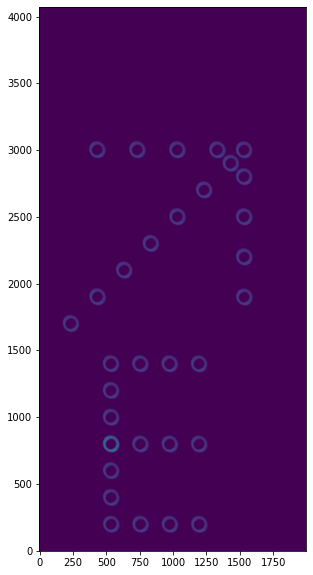

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/repackagerTest/input_w48_wfsEimg/'
butler = dafPersist.Butler(dataRoot, )

dataId = dict(run='9006002', raftName='R04', detectorName='SW0')
post = butler.get('eimage', dataId)
image = post.image.array

# THE UNTRANSPOSED IMAGE, SHOWING WHY UP-DOWN FLIP WAS NEEDED 
# fig,ax = plt.subplots(1,1,figsize=(5,10))
# ax.imshow(image, origin='lower',vmax=2000)

# THE TRANSPOSED IMAGE: SHOWING THE CORRECT ORIENTATION ... 
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=2000)

In [44]:
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/repackagerTest/input_w48_wfsEimg/'
butler = dafPersist.Butler(dataRoot, )


images= dict()
for raftName in ['R40', 'R44', 'R00', 'R04']:
    images[raftName] = dict()
    for detectorName in ['SW0', 'SW1']:     
        dataId = dict(run='9006002', raftName=raftName, detectorName=detectorName)
        post = butler.get('eimage', dataId)
        print('Reading in ', dataId)
        image = post.image.array
        
        images[raftName][detectorName] = image

Reading in  {'run': '9006002', 'raftName': 'R40', 'detectorName': 'SW0'}
Reading in  {'run': '9006002', 'raftName': 'R40', 'detectorName': 'SW1'}
Reading in  {'run': '9006002', 'raftName': 'R44', 'detectorName': 'SW0'}
Reading in  {'run': '9006002', 'raftName': 'R44', 'detectorName': 'SW1'}
Reading in  {'run': '9006002', 'raftName': 'R00', 'detectorName': 'SW0'}
Reading in  {'run': '9006002', 'raftName': 'R00', 'detectorName': 'SW1'}
Reading in  {'run': '9006002', 'raftName': 'R04', 'detectorName': 'SW0'}
Reading in  {'run': '9006002', 'raftName': 'R04', 'detectorName': 'SW1'}


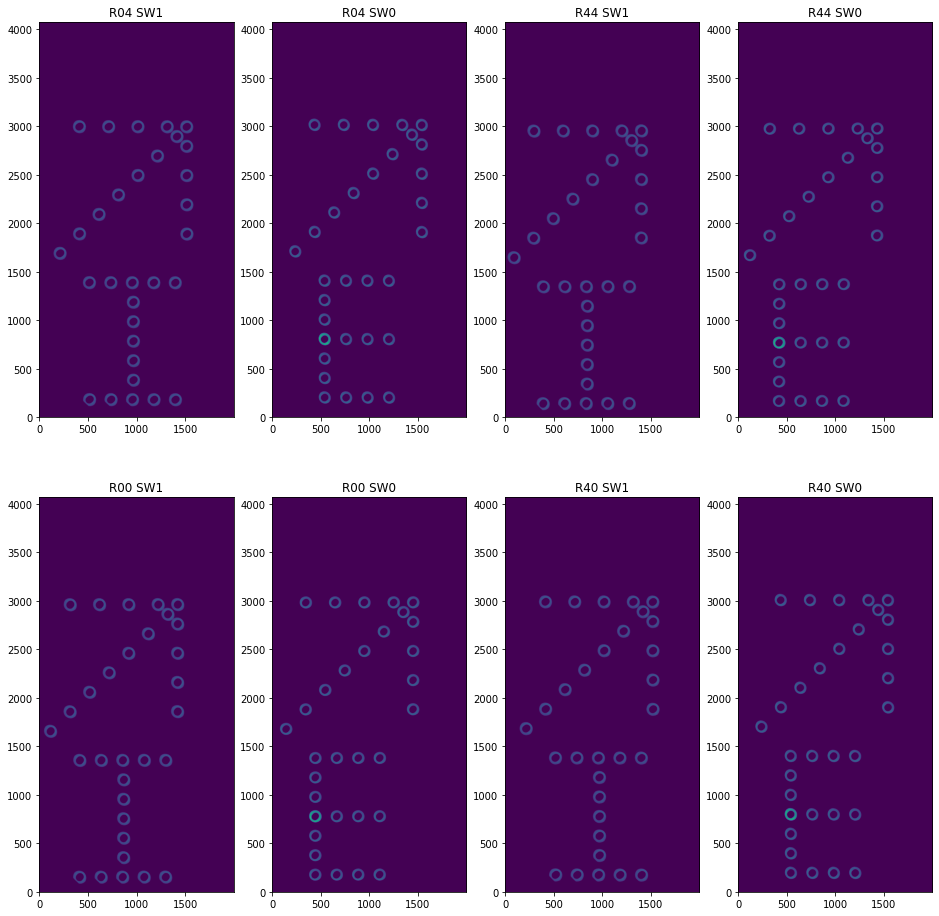

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
a = 4
fig,axs = plt.subplots(2,4,figsize=(4*a,4*a))
ax = np.ravel(axs)
i=0
for raftName in ['R04', 'R44', 'R00', 'R40']:
    for detectorName in ['SW1', 'SW0']:     
        #dataId = dict(run='9006002', raftName=raftName, detectorName=detectorName)
        #post = butler.get('raw', dataId)
        #print('Reading in ', dataId)
        #image = post.image.array
        image = images[raftName][detectorName]
        # THE TRANSPOSED IMAGE: SHOWING THE CORRECT ORIENTATION ... 
        ax[i].imshow(image.T, origin='lower',vmax=1100)
        ax[i].set_title('%s %s'%(raftName, detectorName))
        i+=1 

Repackage comcam and show that works : 

In [50]:
visit_dir = '/project/scichris/repackagerTest/extra'
out_dir = '/project/scichris/repackagerTest/extraRpkgdEimg/'
prefix = 'lsst'
phosim_eimg_files \
            = sorted(glob.glob(os.path.join(visit_dir, f'{prefix}_e_*')))

camera = LsstCam().getCamera()


for phosim_eimg_file  in phosim_eimg_files:
    sensor = repackage_eimage(phosim_eimg_file, camera, out_dir )


Repackaging main  R22 S00
New filename: MC_H_20000217_000031_R22_S00.fits
Saved as /project/scichris/repackagerTest/extraRpkgdEimg/MC_H_20000217_000031_R22_S00.fits

Repackaging main  R22 S01
New filename: MC_H_20000217_000031_R22_S01.fits
Saved as /project/scichris/repackagerTest/extraRpkgdEimg/MC_H_20000217_000031_R22_S01.fits

Repackaging main  R22 S02
New filename: MC_H_20000217_000031_R22_S02.fits
Saved as /project/scichris/repackagerTest/extraRpkgdEimg/MC_H_20000217_000031_R22_S02.fits

Repackaging main  R22 S10
New filename: MC_H_20000217_000031_R22_S10.fits
Saved as /project/scichris/repackagerTest/extraRpkgdEimg/MC_H_20000217_000031_R22_S10.fits

Repackaging main  R22 S11
New filename: MC_H_20000217_000031_R22_S11.fits
Saved as /project/scichris/repackagerTest/extraRpkgdEimg/MC_H_20000217_000031_R22_S11.fits

Repackaging main  R22 S12
New filename: MC_H_20000217_000031_R22_S12.fits
Saved as /project/scichris/repackagerTest/extraRpkgdEimg/MC_H_20000217_000031_R22_S12.fits

Rep

In [53]:
from lsst.utils import getPackageDir
import os 
rawImgFiles = os.path.join('/project/scichris/repackagerTest/extraRpkgdEimg/', "*.fits")
isrDir = os.path.join('/project/scichris/repackagerTest/', 'input_w48_comcamEimg/')

argstring = '%s %s '%(isrDir, rawImgFiles)

obsLsstCmdTaskConfigDir = os.path.join(getPackageDir("obs_lsst"), "config")
eimgConfigFile = os.path.join(obsLsstCmdTaskConfigDir, "phosim", "ingestEimg.py")
if eimgConfigFile is not None:
    argstring += " --configfile %s" % eimgConfigFile
        

print("\nRun in a terminal the following:")
rawDir = os.path.join(isrDir, 'raw')
regFile = os.path.join(isrDir, 'registry*')
print('rm -rf %s'%rawDir)
print('rm %s'%regFile)
print("ingestImages.py %s"%argstring)


Run in a terminal the following:
rm -rf /project/scichris/repackagerTest/input_w48_comcamEimg/raw
rm /project/scichris/repackagerTest/input_w48_comcamEimg/registry*
ingestImages.py /project/scichris/repackagerTest/input_w48_comcamEimg/ /project/scichris/repackagerTest/extraRpkgdEimg/*.fits  --configfile /project/scichris/dev/obs_lsst/config/phosim/ingestEimg.py


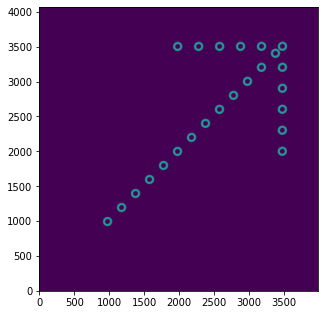

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/repackagerTest/input_w48_comcamEimg/'
butler = dafPersist.Butler(dataRoot, )

dataId = dict(run='9006001', raftName='R22', detectorName='S00')
post = butler.get('eimage', dataId)
image = post.image.array

# THE UNTRANSPOSED IMAGE, SHOWING WHY UP-DOWN FLIP WAS NEEDED 
# fig,ax = plt.subplots(1,1,figsize=(5,10))
# ax.imshow(image, origin='lower',vmax=2000)

# THE TRANSPOSED IMAGE: SHOWING THE CORRECT ORIENTATION ... 
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=500)

Also, tried to ingest with just `ingestImages.py`:   


In [1]:
from lsst.utils import getPackageDir
import os 
rawImgFiles = os.path.join('/project/scichris/repackagerTest/extraRpkgdEimg/', "*.fits")
isrDir = os.path.join('/project/scichris/repackagerTest/', 'input_w50_comcamEimg/')

argstring = '%s %s '%(isrDir, rawImgFiles)

print("\nRun in a terminal the following:")
rawDir = os.path.join(isrDir, 'raw')
regFile = os.path.join(isrDir, 'registry*')
print('rm -rf %s'%rawDir)
print('rm %s'%regFile)
print("ingestImages.py %s"%argstring)


Run in a terminal the following:
rm -rf /project/scichris/repackagerTest/input_w50_comcamEimg/raw
rm /project/scichris/repackagerTest/input_w50_comcamEimg/registry*
ingestImages.py /project/scichris/repackagerTest/input_w50_comcamEimg/ /project/scichris/repackagerTest/extraRpkgdEimg/*.fits 


In [4]:
from lsst.daf.butler import Butler


In [5]:
Butler?

Init signature:
Butler(
    config: 'Union[Config, str, None]' = None,
    *,
    butler: 'Optional[Butler]' = None,
    collections: 'Any' = None,
    run: 'Optional[str]' = None,
    tags: 'Iterable[str]' = (),
    chains: 'Optional[Mapping[str, Any]]' = None,
    searchPaths: 'Optional[List[str]]' = None,
    writeable: 'Optional[bool]' = None,
)
Docstring:     
Main entry point for the data access system.

Parameters
----------
config : `ButlerConfig`, `Config` or `str`, optional.
    Configuration. Anything acceptable to the
    `ButlerConfig` constructor.  If a directory path
    is given the configuration will be read from a ``butler.yaml`` file in
    that location.  If `None` is given default values will be used.
butler : `Butler`, optional.
    If provided, construct a new Butler that uses the same registry and
    datastore as the given one, but with the given collection and run.
    Incompatible with the ``config``, ``searchPaths``, and ``writeable``
    arguments.
collecti

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/repackagerTest/input_w50_comcamEimg/'
butler = dafPersist.Butler(dataRoot, )

dataId = dict(run='9006001', raftName='R22', detectorName='S00')
post = butler.get('eimage', dataId)
image = post.image.array

# THE UNTRANSPOSED IMAGE, SHOWING WHY UP-DOWN FLIP WAS NEEDED 
# fig,ax = plt.subplots(1,1,figsize=(5,10))
# ax.imshow(image, origin='lower',vmax=2000)

# THE TRANSPOSED IMAGE: SHOWING THE CORRECT ORIENTATION ... 
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmax=500)

NoResults: No locations for get: datasetType:eimage dataId:DataId(initialdata={'run': '9006001', 'raftName': 'R22', 'detectorName': 'S00'}, tag=set())

In [61]:
images= dict()
raftName = 'R22'
for detectorName in ['S00', 'S01','S02',
                    'S10','S11','S12',
                    'S20','S21','S22']:     
    dataId = dict(run='9006001', raftName=raftName, detectorName=detectorName)
    post = butler.get('eimage', dataId)
    print('Reading in ', dataId)
    image = post.image.array

    images[detectorName] = image

Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S00'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S01'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S02'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S10'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S11'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S12'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S20'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S21'}
Reading in  {'run': '9006001', 'raftName': 'R22', 'detectorName': 'S22'}


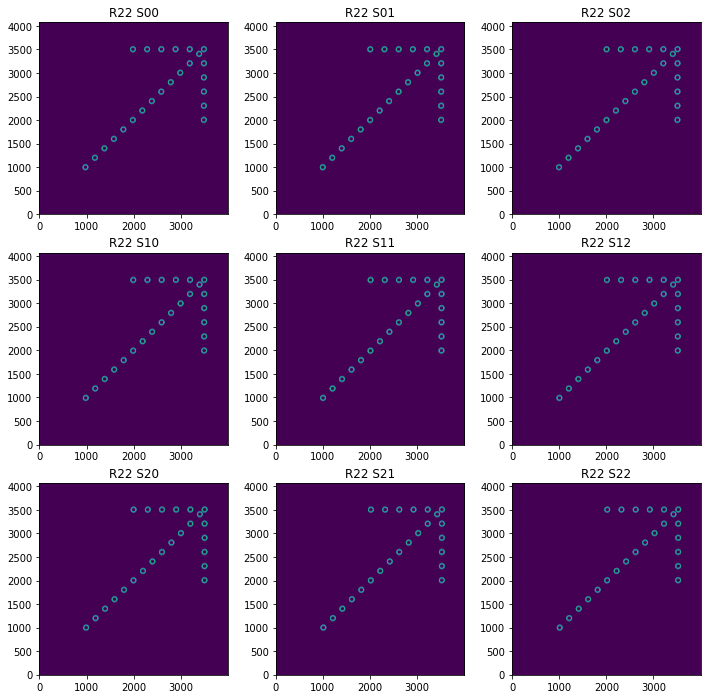

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

a = 4
fig,axs = plt.subplots(3,3,figsize=(3*a,3*a))
ax = np.ravel(axs)
i=0
raftName = 'R22'

for detectorName in images.keys():# ['SW1', 'SW0']:     
    image = images[detectorName]
    # THE TRANSPOSED IMAGE: SHOWING THE CORRECT ORIENTATION ... 
    ax[i].imshow(image.T, origin='lower',vmax=500)
    ax[i].set_title('%s %s'%(raftName, detectorName))
    i+=1 